# Gesture recognition networks

### Imports

In [44]:
import os
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

### Configuration

In [81]:

class CONFIG:
    model_path = './BestModel.pt'
    num_epochs = 100
    lr = 1e-4
    batch_size = 10
    img_size = 224
    dataset = "division_5" # division_5 / division_4 depends on dataset
    rgb_depth = "RGB" # RGB / Depth depends on dataset

### Creating sorted classes for dataset



In [75]:
cfg = CONFIG()
data_dir = r".\..\EURECOM_Kinect_Face_Dataset\EURECOM_Kinect_Face_Dataset"
destination_dir = r".\HeadDataset"
os.makedirs(destination_dir, exist_ok=True)

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder}")
        
        # Loop through each class subfolder #
        for class_folder in os.listdir(folder_path):
            class_folder_path = os.path.join(folder_path, class_folder)
            
            if os.path.isdir(class_folder_path) and class_folder == "s2":
                print(f"  Class folder: {class_folder}")
                
                for class_Sfolder in os.listdir(class_folder_path):
                    class_Subfolder_path = os.path.join(class_folder_path, class_Sfolder)
                    
                    if os.path.isdir(class_Subfolder_path) and class_Sfolder == cfg.rgb_depth:
                        if class_Sfolder == "Depth":
                            class_Subfolder_path = os.path.join(class_Subfolder_path,"DepthBMP")
                        print(f"    Class Sub folder: {class_Sfolder}")

                        for filename in os.listdir(class_Subfolder_path):
                            file_path = os.path.join(class_Subfolder_path, filename)
                            if cfg.dataset == "division_4":
                                # Left Profile
                                if os.path.isfile(file_path) and "LeftProfile" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\001", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\001", filename))
                                # Light on
                                if os.path.isfile(file_path) and "LightOn" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\002", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\002", filename))
                                # RightProfile
                                if os.path.isfile(file_path) and "RightProfile" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\008", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\008", filename))
                                # OcclusionPaper
                                if os.path.isfile(file_path) and "OcclusionPaper" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\006", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\006", filename))
                            if cfg.dataset == "division_5":
                                # Neutral
                                if os.path.isfile(file_path) and "Neutral" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\003", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\003", filename))
                                # OcclusionEyes
                                if os.path.isfile(file_path) and "OcclusionEyes" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\004", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\004", filename))
                                # OcclusionMouth
                                if os.path.isfile(file_path) and "OcclusionMouth" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\005", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\005", filename))
                                # OpenMouth
                                if os.path.isfile(file_path) and "OpenMouth" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\007", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\007", filename))
                                # Smile
                                if os.path.isfile(file_path) and "Smile" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\009", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\009", filename))

Processing folder: 0001
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0001_s2_Neutral.bmp
        Moving file: rgb_0001_s2_OcclusionEyes.bmp
        Moving file: rgb_0001_s2_OcclusionMouth.bmp
        Moving file: rgb_0001_s2_OpenMouth.bmp
        Moving file: rgb_0001_s2_Smile.bmp
Processing folder: 0002
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0002_s2_Neutral.bmp
        Moving file: rgb_0002_s2_OcclusionEyes.bmp
        Moving file: rgb_0002_s2_OcclusionMouth.bmp
        Moving file: rgb_0002_s2_OpenMouth.bmp
        Moving file: rgb_0002_s2_Smile.bmp
Processing folder: 0003
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0003_s2_Neutral.bmp
        Moving file: rgb_0003_s2_OcclusionEyes.bmp
        Moving file: rgb_0003_s2_OcclusionMouth.bmp
        Moving file: rgb_0003_s2_OpenMouth.bmp
        Moving file: rgb_0003_s2_Smile.bmp
Processing folder: 0004
  Class folder: s2
    Class Sub folder: RGB
        Mo

### CNN structure

In [79]:
class CNN6Conv6FC(nn.Module):
    def __init__(self, num_classes):
        super(CNN6Conv6FC, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, num_classes)  
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        
        x = self.fc6(x)
        
        return x


### Dataloader

In [80]:

transform = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),  
    transforms.ToTensor(),        
    transforms.Grayscale(), 
    transforms.Normalize((0.5), (0.5))  
])

dataset = datasets.ImageFolder(root=r'.\HeadDataset', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset =  data.random_split(dataset, [train_size, test_size])

trainloader =  data.DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
testloader =  data.DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)
num_classes = len(dataset.class_to_idx)
print(num_classes)

5


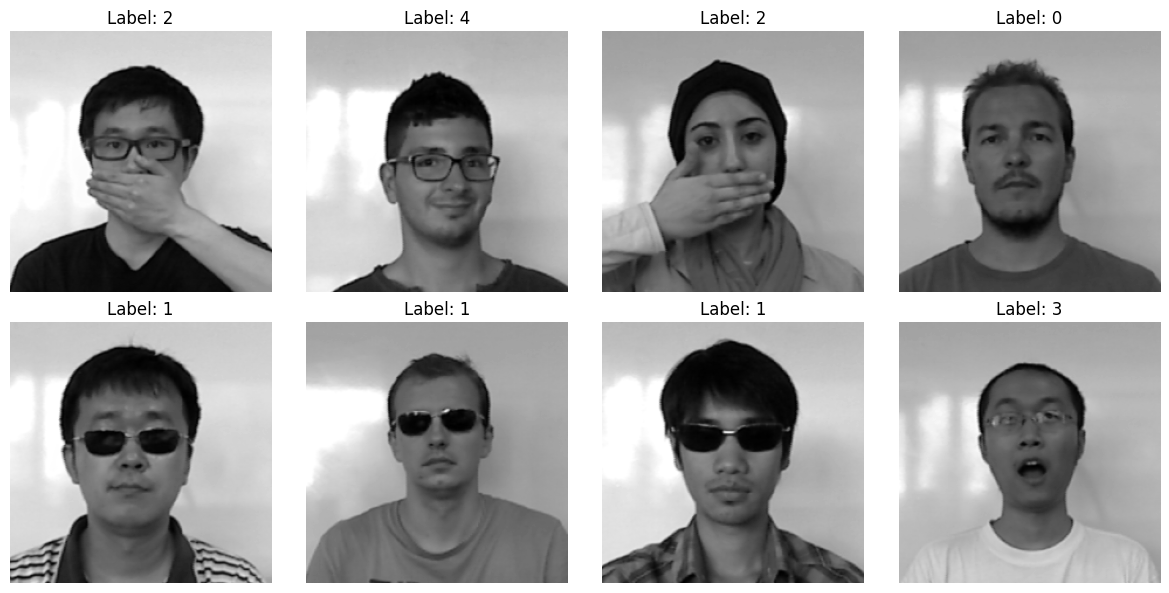

In [82]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

random_indices = np.random.choice(images.size(0), 8, replace=False)
images = images[random_indices]
labels = labels[random_indices]

# Convert images to numpy and plot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(8):
    ax = axes[i//4, i%4]
    image = images[i].squeeze(0).numpy() 
    ax.imshow(image, cmap='gray')  
    ax.axis('off')
    ax.set_title(f"Label: {labels[i].item()}")

plt.tight_layout()
plt.show()


### NET Setup and training

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN6Conv6FC(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)  # Adam optimizer with learning rate

Using device: cuda


In [84]:
best_accuracy = 0.0
for epoch in range(cfg.num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Create a progress bar for the current epoch
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{cfg.num_epochs}", unit="batch")

    for i, (inputs, labels) in enumerate(progress_bar):  
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Update progress bar with current loss and accuracy
        progress_bar.set_postfix({
            'loss': loss.item(),
            'accuracy': (correct_predictions / total_predictions) * 100
        })

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    
    print(f"Epoch {epoch+1}/{cfg.num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")

    # Validation loop
    model.eval()  
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():  
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    validation_accuracy = (correct_predictions / total_predictions) * 100
    print(f"Validation Accuracy: {validation_accuracy:.2f}%")
    if validation_accuracy > best_accuracy:
        torch.save(model.state_dict(), cfg.model_path)
print("Training finished.")


Epoch 1/100:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch 1/100: 100%|██████████| 21/21 [00:11<00:00,  1.76batch/s, loss=1.63, accuracy=17.8]


Epoch 1/100 - Loss: 1.6156 - Accuracy: 17.79%
Validation Accuracy: 19.23%


Epoch 2/100: 100%|██████████| 21/21 [00:11<00:00,  1.81batch/s, loss=1.59, accuracy=22.1]


Epoch 2/100 - Loss: 1.6061 - Accuracy: 22.12%
Validation Accuracy: 15.38%


Epoch 3/100: 100%|██████████| 21/21 [00:11<00:00,  1.84batch/s, loss=1.52, accuracy=28.8]


Epoch 3/100 - Loss: 1.5669 - Accuracy: 28.85%
Validation Accuracy: 30.77%


Epoch 4/100: 100%|██████████| 21/21 [00:12<00:00,  1.70batch/s, loss=1.34, accuracy=48.1]


Epoch 4/100 - Loss: 1.4016 - Accuracy: 48.08%
Validation Accuracy: 40.38%


Epoch 5/100: 100%|██████████| 21/21 [00:11<00:00,  1.80batch/s, loss=0.889, accuracy=52.4]


Epoch 5/100 - Loss: 1.0384 - Accuracy: 52.40%
Validation Accuracy: 34.62%


Epoch 6/100: 100%|██████████| 21/21 [00:11<00:00,  1.84batch/s, loss=0.786, accuracy=53.8]


Epoch 6/100 - Loss: 0.7924 - Accuracy: 53.85%
Validation Accuracy: 57.69%


Epoch 7/100: 100%|██████████| 21/21 [00:11<00:00,  1.80batch/s, loss=0.783, accuracy=60.6]


Epoch 7/100 - Loss: 0.7031 - Accuracy: 60.58%
Validation Accuracy: 51.92%


Epoch 8/100: 100%|██████████| 21/21 [00:11<00:00,  1.82batch/s, loss=0.97, accuracy=59.6] 


Epoch 8/100 - Loss: 0.6793 - Accuracy: 59.62%
Validation Accuracy: 73.08%


Epoch 9/100: 100%|██████████| 21/21 [00:11<00:00,  1.82batch/s, loss=0.552, accuracy=69.2]


Epoch 9/100 - Loss: 0.6069 - Accuracy: 69.23%
Validation Accuracy: 55.77%


Epoch 10/100: 100%|██████████| 21/21 [00:11<00:00,  1.86batch/s, loss=0.493, accuracy=74]  


Epoch 10/100 - Loss: 0.5231 - Accuracy: 74.04%
Validation Accuracy: 75.00%


Epoch 11/100: 100%|██████████| 21/21 [00:11<00:00,  1.87batch/s, loss=0.796, accuracy=84.6]


Epoch 11/100 - Loss: 0.4401 - Accuracy: 84.62%
Validation Accuracy: 69.23%


Epoch 12/100: 100%|██████████| 21/21 [00:11<00:00,  1.85batch/s, loss=0.285, accuracy=84.1]


Epoch 12/100 - Loss: 0.3930 - Accuracy: 84.13%
Validation Accuracy: 71.15%


Epoch 13/100: 100%|██████████| 21/21 [00:11<00:00,  1.77batch/s, loss=0.176, accuracy=85.1]


Epoch 13/100 - Loss: 0.3069 - Accuracy: 85.10%
Validation Accuracy: 71.15%


Epoch 14/100: 100%|██████████| 21/21 [00:11<00:00,  1.78batch/s, loss=0.124, accuracy=90.9] 


Epoch 14/100 - Loss: 0.2760 - Accuracy: 90.87%
Validation Accuracy: 75.00%


Epoch 15/100: 100%|██████████| 21/21 [00:11<00:00,  1.83batch/s, loss=0.0446, accuracy=91.3]


Epoch 15/100 - Loss: 0.2382 - Accuracy: 91.35%
Validation Accuracy: 71.15%


Epoch 16/100: 100%|██████████| 21/21 [00:10<00:00,  2.00batch/s, loss=0.128, accuracy=95.7] 


Epoch 16/100 - Loss: 0.1380 - Accuracy: 95.67%
Validation Accuracy: 67.31%


Epoch 17/100: 100%|██████████| 21/21 [00:10<00:00,  2.00batch/s, loss=0.0412, accuracy=98.6] 


Epoch 17/100 - Loss: 0.0671 - Accuracy: 98.56%
Validation Accuracy: 75.00%


Epoch 18/100: 100%|██████████| 21/21 [00:10<00:00,  1.99batch/s, loss=0.0171, accuracy=99]   


Epoch 18/100 - Loss: 0.0637 - Accuracy: 99.04%
Validation Accuracy: 69.23%


Epoch 19/100: 100%|██████████| 21/21 [00:10<00:00,  1.99batch/s, loss=0.0172, accuracy=99]   


Epoch 19/100 - Loss: 0.0341 - Accuracy: 99.04%
Validation Accuracy: 76.92%


Epoch 20/100: 100%|██████████| 21/21 [00:10<00:00,  1.95batch/s, loss=0.202, accuracy=99]    


Epoch 20/100 - Loss: 0.0434 - Accuracy: 99.04%
Validation Accuracy: 73.08%


Epoch 21/100: 100%|██████████| 21/21 [00:10<00:00,  1.98batch/s, loss=0.00848, accuracy=95.7]


Epoch 21/100 - Loss: 0.1444 - Accuracy: 95.67%
Validation Accuracy: 75.00%


Epoch 22/100: 100%|██████████| 21/21 [00:10<00:00,  1.95batch/s, loss=0.0422, accuracy=96.2] 


Epoch 22/100 - Loss: 0.1038 - Accuracy: 96.15%
Validation Accuracy: 67.31%


Epoch 23/100: 100%|██████████| 21/21 [00:10<00:00,  1.99batch/s, loss=0.036, accuracy=98.6] 


Epoch 23/100 - Loss: 0.0965 - Accuracy: 98.56%
Validation Accuracy: 73.08%


Epoch 24/100: 100%|██████████| 21/21 [00:10<00:00,  2.00batch/s, loss=0.0209, accuracy=99]   


Epoch 24/100 - Loss: 0.0385 - Accuracy: 99.04%
Validation Accuracy: 67.31%


Epoch 25/100: 100%|██████████| 21/21 [00:10<00:00,  1.99batch/s, loss=0.0171, accuracy=100] 


Epoch 25/100 - Loss: 0.0162 - Accuracy: 100.00%
Validation Accuracy: 78.85%


Epoch 26/100: 100%|██████████| 21/21 [00:10<00:00,  1.95batch/s, loss=0.0703, accuracy=99.5] 


Epoch 26/100 - Loss: 0.0204 - Accuracy: 99.52%
Validation Accuracy: 78.85%


Epoch 27/100: 100%|██████████| 21/21 [00:10<00:00,  1.99batch/s, loss=0.00147, accuracy=99.5]


Epoch 27/100 - Loss: 0.0360 - Accuracy: 99.52%
Validation Accuracy: 82.69%


Epoch 28/100: 100%|██████████| 21/21 [00:10<00:00,  2.01batch/s, loss=0.0253, accuracy=100] 


Epoch 28/100 - Loss: 0.0128 - Accuracy: 100.00%
Validation Accuracy: 80.77%


Epoch 29/100: 100%|██████████| 21/21 [00:10<00:00,  1.96batch/s, loss=0.0017, accuracy=100] 


Epoch 29/100 - Loss: 0.0106 - Accuracy: 100.00%
Validation Accuracy: 73.08%


Epoch 30/100: 100%|██████████| 21/21 [00:10<00:00,  1.97batch/s, loss=0.000933, accuracy=100]


Epoch 30/100 - Loss: 0.0045 - Accuracy: 100.00%
Validation Accuracy: 75.00%


Epoch 31/100: 100%|██████████| 21/21 [00:09<00:00,  2.10batch/s, loss=0.00047, accuracy=100] 


Epoch 31/100 - Loss: 0.0018 - Accuracy: 100.00%
Validation Accuracy: 75.00%


Epoch 32/100: 100%|██████████| 21/21 [00:10<00:00,  1.95batch/s, loss=0.000724, accuracy=100]


Epoch 32/100 - Loss: 0.0012 - Accuracy: 100.00%
Validation Accuracy: 71.15%


Epoch 33/100: 100%|██████████| 21/21 [00:10<00:00,  1.98batch/s, loss=0.00126, accuracy=100] 


Epoch 33/100 - Loss: 0.0010 - Accuracy: 100.00%
Validation Accuracy: 71.15%


Epoch 34/100: 100%|██████████| 21/21 [00:10<00:00,  2.01batch/s, loss=0.000841, accuracy=100]


Epoch 34/100 - Loss: 0.0008 - Accuracy: 100.00%
Validation Accuracy: 73.08%


Epoch 35/100: 100%|██████████| 21/21 [00:10<00:00,  2.04batch/s, loss=0.000596, accuracy=100]


Epoch 35/100 - Loss: 0.0008 - Accuracy: 100.00%
Validation Accuracy: 76.92%


Epoch 36/100: 100%|██████████| 21/21 [00:10<00:00,  2.05batch/s, loss=0.000295, accuracy=100]


Epoch 36/100 - Loss: 0.0005 - Accuracy: 100.00%
Validation Accuracy: 76.92%


Epoch 37/100: 100%|██████████| 21/21 [00:10<00:00,  1.96batch/s, loss=0.00123, accuracy=100] 


Epoch 37/100 - Loss: 0.0006 - Accuracy: 100.00%
Validation Accuracy: 75.00%


Epoch 38/100: 100%|██████████| 21/21 [00:10<00:00,  1.99batch/s, loss=0.000386, accuracy=100]


Epoch 38/100 - Loss: 0.0005 - Accuracy: 100.00%
Validation Accuracy: 75.00%


Epoch 39/100: 100%|██████████| 21/21 [00:10<00:00,  2.10batch/s, loss=0.000366, accuracy=100]


Epoch 39/100 - Loss: 0.0005 - Accuracy: 100.00%
Validation Accuracy: 76.92%


Epoch 40/100: 100%|██████████| 21/21 [00:10<00:00,  2.08batch/s, loss=0.000563, accuracy=100]


Epoch 40/100 - Loss: 0.0005 - Accuracy: 100.00%
Validation Accuracy: 76.92%


Epoch 41/100: 100%|██████████| 21/21 [00:10<00:00,  2.01batch/s, loss=0.000334, accuracy=100]


Epoch 41/100 - Loss: 0.0004 - Accuracy: 100.00%
Validation Accuracy: 75.00%


Epoch 42/100: 100%|██████████| 21/21 [00:10<00:00,  1.96batch/s, loss=0.000361, accuracy=100]


Epoch 42/100 - Loss: 0.0004 - Accuracy: 100.00%
Validation Accuracy: 75.00%


Epoch 43/100: 100%|██████████| 21/21 [00:10<00:00,  2.07batch/s, loss=0.00024, accuracy=100] 


Epoch 43/100 - Loss: 0.0004 - Accuracy: 100.00%
Validation Accuracy: 75.00%


Epoch 44/100: 100%|██████████| 21/21 [00:10<00:00,  2.06batch/s, loss=0.000563, accuracy=100]


Epoch 44/100 - Loss: 0.0004 - Accuracy: 100.00%
Validation Accuracy: 76.92%


Epoch 45/100: 100%|██████████| 21/21 [00:10<00:00,  2.05batch/s, loss=0.000476, accuracy=100]


Epoch 45/100 - Loss: 0.0004 - Accuracy: 100.00%
Validation Accuracy: 73.08%


Epoch 46/100: 100%|██████████| 21/21 [00:10<00:00,  2.07batch/s, loss=0.000618, accuracy=100]


Epoch 46/100 - Loss: 0.0003 - Accuracy: 100.00%
Validation Accuracy: 76.92%


Epoch 47/100: 100%|██████████| 21/21 [00:10<00:00,  2.06batch/s, loss=0.000246, accuracy=100]


Epoch 47/100 - Loss: 0.0003 - Accuracy: 100.00%
Validation Accuracy: 73.08%


Epoch 48/100: 100%|██████████| 21/21 [00:09<00:00,  2.11batch/s, loss=0.000201, accuracy=100]


Epoch 48/100 - Loss: 0.0003 - Accuracy: 100.00%
Validation Accuracy: 75.00%


Epoch 49/100: 100%|██████████| 21/21 [00:09<00:00,  2.10batch/s, loss=0.000291, accuracy=100]


Epoch 49/100 - Loss: 0.0003 - Accuracy: 100.00%
Validation Accuracy: 76.92%


Epoch 50/100: 100%|██████████| 21/21 [00:10<00:00,  2.07batch/s, loss=0.00177, accuracy=100] 


Epoch 50/100 - Loss: 0.0003 - Accuracy: 100.00%
Validation Accuracy: 76.92%


Epoch 51/100: 100%|██████████| 21/21 [00:10<00:00,  2.00batch/s, loss=0.0003, accuracy=100]  


Epoch 51/100 - Loss: 0.0002 - Accuracy: 100.00%
Validation Accuracy: 73.08%


Epoch 52/100: 100%|██████████| 21/21 [00:10<00:00,  2.00batch/s, loss=0.000633, accuracy=100]


Epoch 52/100 - Loss: 0.0003 - Accuracy: 100.00%
Validation Accuracy: 75.00%


Epoch 53/100: 100%|██████████| 21/21 [00:10<00:00,  2.08batch/s, loss=0.000659, accuracy=100]


Epoch 53/100 - Loss: 0.0003 - Accuracy: 100.00%
Validation Accuracy: 76.92%


Epoch 54/100: 100%|██████████| 21/21 [00:12<00:00,  1.72batch/s, loss=0.000112, accuracy=100]


Epoch 54/100 - Loss: 0.0003 - Accuracy: 100.00%
Validation Accuracy: 76.92%


Epoch 55/100: 100%|██████████| 21/21 [00:11<00:00,  1.79batch/s, loss=0.000178, accuracy=100]


Epoch 55/100 - Loss: 0.0002 - Accuracy: 100.00%


KeyboardInterrupt: 

In [90]:
import torch
import cv2
import numpy as np
from torchvision import transforms

# Load the pre-trained model
model = CNN6Conv6FC(num_classes=num_classes)
state_dict = torch.load('BestModel.pt')
model.load_state_dict(state_dict)
model.eval()  # Set model to evaluation mode

# Define transformations for input preprocessing
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Adjust size as per your model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the camera (0 for the default camera)
camera_index = 0
cap = cv2.VideoCapture(camera_index)

if not cap.isOpened():
    print("Error: Unable to access the camera")
    exit()

print("Press 'q' to exit")

# Object detection loop
while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to capture frame")
        break

    # Preprocess the frame
    input_tensor = preprocess(frame).unsqueeze(0)  # Add batch dimension

    # Model inference
    with torch.no_grad():
        outputs = model(input_tensor)

    # Postprocess predictions (example: assuming outputs are class probabilities)
    predicted_class = torch.argmax(outputs, dim=1).item()

    # Map predicted_class to human-readable labels (assuming a mapping exists)
    class_labels = {0: 'Cat', 1: 'Dog', 2: 'Car', 3: 'Person'}  # Example mapping
    label = class_labels.get(predicted_class, 'Unknown')

    # Draw the label on the frame
    cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Object Detection', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


C:\Users\david\AppData\Local\Temp\ipykernel_22412\2971604382.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('BestModel.pt')


: 